In [24]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv1D, LayerNormalization
from tensorflow.keras.layers import LeakyReLU, BatchNormalization, Flatten, MaxPooling1D, Input
import numpy as np
from sincnet_tensorflow import SincConv1D, LayerNorm

from keras.utils import Sequence
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import soundfile as sf
import glob
from keras.models import Sequential
import torch
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint
RANDOM_STATE = 42

Deep learning is progressively gaining popularity as alternative option to i-vectors for speaker recognition. Promising results have been recently obtained with CNNs when they are fed with raw speech samples directly. Rather than employing standard hand-crafted features, this paper proposes a novel CNN architecture, called **SincNet**, that encourages the first convolutional layer to discover more meaningful filters. SincNet is based on parametrized sinc functions, which implement band-pass filter. In contrast to standard CNNs, that learn all elements of each filter, only low and high cutoff frequencies are directly learned from data with proposed method. This offers a very compact and efficient way to derive a customized filter bank specificaly tuned for desired application.

**I-vectors**, short for "identity vectors," are a representation used in speaker recognition and speech processing. They are a way to capture the characteristics of a speaker's voice in a compact numerical format. I-vectors are widely used in various applications, including speaker verification, speaker identification, and speaker clustering. \\
A **band-pass** is a filter that passes frequencies within a certain range and rejects frequencies outside that range. The range of frequencies that the filter passes is called passband, and the frequencies that are rejected are called the stopband.

# The SincNet architecture
The first layer of a standard CNN performs a set of time-domain convolutions between the input waveform and some Finite Impullse Response(FIR) filters. Each convolution is defined as follows:
$$ y[n] = x[n] * h[n] = \sum_{l=0}^{L-1}x[l]\cdot h[n-l] $$ 
wher $x[n]$ is a chunk of speech signal, $ h[n] $ is the filter of length $ L $, and $y[n]$ is the filtered output. \\ 
In the standard CNNs, all L elements of each filter are learned from data. \\
Converselym the proposed SincNet performs the convolution with predefined function $g$ that depends on few learnable parameters $\theta$ only.

A resonabe choice, inspired by standard fitering in digital signall processing, is to define $g$ such that a filter-bank composed of rectangular bandpass filters is employed. In the frequency domain, the magnitude of a generic bandpass filter can be written as the difference between two low-pass filters: <br><br>
$$ G[f, f_1, f_2] = rect(\frac{f}{2f_2}) - rect(\frac{f}{2f_1}),$$
where $f_1$ and $f_2$ are the learned low and high cutoff frequencies, and $rect(\cdot)$  is the rectangular function in the magnitude frequency domain. After returning to the time domain ( using the inverse Fourier transform), the reference function $g$ becomes: <br><br>
$$
g[n, f_1, f_2] = 2f_2sinc(2\pi{}f_2n) - 2f_1sinc(2\pi{}f_1n),
$$ <br>
where the sinc function is defined as $$ sinc(x) = sin(x)/x$$. <br>
The cut-off frequencies can be initialized randomy in the range $[0, f_s]$. As alternative, filters can be initialized with cutoff frequencies of the mel-scale filter-bank which has advantage of directy allocating more filters in the lower part of the spectrum, where many crucial clues about the speaker identity are located. <br><br>
An ideal bandpass fitler requires an infinite number of elements $L$. Any truncation of $g$ thus leads to an approximation of the idea fiter, characterized by ripples in the passband and limited attenuation in the stopband. The popular solution to mitigate this issue is windowing. Windowing is performed by multiplying the truncted function $g$ with a windows $w$, which aims to smooth out the abrupt discontinuties at the ends of $g$: <br><br>
$$
g_w[n, f_1, f_2] = g[n, f_1, f_2]\cdot w[n].
$$<br><br>
This model uses the popular Hamming window, defined as follows: <br><br>
$$
w[n] = 0.54 -0.46\cdot\cos(\frac{2\pi{}n}{L}).
$$

 <img src='assets/architecture.png'>

Loading normalized TIMIT dataset:
1. Setting frequency, frame size, frame stride and batch size for this dataset

In [3]:
sample_frequency = 16_000 # 16kHz
frame_size = 0.300 # 300ms
frame_stride = 0.01 # 10ms
mux_num_frames = 100

frame_length = int(round(frame_size * sample_frequency))
frame_step = int(round(frame_stride * sample_frequency))

batch_size = 128


print("Input length: {} ({}s)".format(frame_length, frame_size* mux_num_frames))
print("Input shape: {}".format((batch_size, frame_length)))

Input length: 4800 (30.0s)
Input shape: (128, 4800)


In [4]:
# Spliting signal in parts
def get_frames_indices(filename):
    
    signal, fs = sf.read(filename)
    
    # Determine number of frames
    signal_length = len(signal)
    assert signal_length > frame_length
    num_frames = int(np.floor((signal_length - frame_length) / frame_step))
    
    num_frames = min(num_frames, mux_num_frames)
    
    return np.arange(0, num_frames*frame_step, frame_step)

2. Loading TIMIT dataset into vectors X and y. Function **get_frame_indices** will split starting signal in smaller parts where every part will have same size (frame step)

In [5]:
from collections import defaultdict
import os
def load_timit_speaker_dataset(data_dir):
    speaker_data = defaultdict(list)

    # Iterate through the dataset directory
    for root, dirs, files in os.walk(data_dir):
        for file in files:
            if file.endswith(".wav"):
                speaker_id = os.path.basename(root)
                audio_path = os.path.join(root, file)
                speaker_data[speaker_id].append(audio_path)

    return speaker_data

# Provide the path to your TIMIT dataset directory
data_dir = r"C:\Users\grmus\Desktop\naucno_izracunavanje\project\timit\train"
speaker_dataset = load_timit_speaker_dataset(data_dir)


X = []
y = []

for speker_id, audio_paths in speaker_dataset.items():
    for audio_path in audio_paths:
        frames = get_frames_indices(audio_path)
        
        for frame in frames:
            X.append((audio_path, frame))
            y.append(speker_id)
        
        


3. Translating id's from speakers into encoded values

In [7]:
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder instance
label_encoder = LabelEncoder()

# Fit and transform the target column
y = label_encoder.fit_transform(y)

4. Creating generator for dataset and spliting dataset into train and test sets

In [8]:
class TimitSpeachGenerator(Sequence):
    
    def __init__(self, X, y, batch_size):
        self.X = X
        self.y = y 
        self.batch_size = batch_size
        
    def __len__(self):
        nb_batches = len(self.y) / float(self.batch_size)
        return np.ceil(nb_batches).astype(np.int32)
  
    
    def __getitem__(self, batch_id):
        X_batch = np.zeros((self.batch_size, frame_length, 1))
        y_batch = np.zeros(self.batch_size)
        
        for i in range(self.batch_size):
            id = batch_id * self.batch_size +i
            if id >= len(self.y):
                id = np.random.randint(0, len(self.y))
                
            path, frame = self.X[id]
            signal, fs = sf.read(path)
            
            X_batch[i, :, 0] = signal[frame:frame+frame_length]
            y_batch[i] = self.y[id]
            
        return X_batch, y_batch
    



In [12]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)
train_gen = TimitSpeachGenerator(X_train, y_train, batch_size)
val_gen = TimitSpeachGenerator(X_val, y_val, batch_size)

In [15]:
print("Number of training batches:", len(train_gen))
print("Number of validation batches:", len(val_gen))
number_of_unique_speakers = len(np.unique(y))
print("Number of unique speakers:", number_of_unique_speakers)

Number of training batches: 2308
Number of validation batches: 577
Number of unique speakers: 462


4. Creating class for the frist layer in this model

In [16]:
import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K

import numpy as np

class SincConvFast(Layer):
    '''
    Sinc-based convolution Keras layer

    Parameters
    ----------
    nb_filters : `int`
        Number of filters (= number of output channels).
    kernel_size : `int`
        Convolution filter width/length (will be increased by one if even).
    sample_freq : `int`
        Sample rate of input audio.
    stride : `int`
        Convolution stride param. Defaults to 1.
    padding : `string`
        Convolution padding param. Defaults to "VALID".
    min_low_hz : `int`
        Minimum lowest frequency for pass band filter. Defaults to 50.
    min_band_hz : `int`
        Minimum frequency for pass band filter. Defaults to 50.

    Reference
    ---------
    Mirco Ravanelli, Yoshua Bengio,
    "Speaker Recognition from raw waveform with SincNet".
    https://arxiv.org/abs/1808.00158
    '''

    @staticmethod
    def hz_to_mel(hz):
        return 2595.0 * np.log10(1.0 + hz / 700.0)

    @staticmethod
    def mel_to_hz(mels):
        return 700.0 * (10.0 ** (mels / 2595.0) - 1.0)

    def __init__(self, nb_filters, kernel_size, sample_freq,
                 stride=1, padding="VALID", min_low_hz=50, min_band_hz=50,
                 **kwargs):
        super(SincConvFast, self).__init__(**kwargs)

        self.nb_filters = nb_filters
        self.kernel_size = kernel_size
        self.sample_freq = sample_freq
        self.stride = stride
        self.padding = padding
        self.min_low_hz = min_low_hz
        self.min_band_hz = min_band_hz

        # Force filter size to be odd for later optimizations with symmetry
        if kernel_size % 2 == 0:
            self.kernel_size = self.kernel_size + 1

        # Set trainable parameters
        self.low_hz = self.add_weight(
            name='low_hz',
            shape=(self.nb_filters,),
            initializer="zeros",
            trainable=True)
        self.band_hz = self.add_weight(
            name='band_hz',
            shape=(self.nb_filters,),
            initializer="zeros",
            trainable=True)
        
        # Initialize weights with frequencies of the mel-scale filter-bank
        low_freq_mel = self.hz_to_mel(30)
        high_freq_mel = self.hz_to_mel(self.sample_freq / 2 - (self.min_low_hz + self.min_band_hz))
        mel_points = np.linspace(low_freq_mel, high_freq_mel, num=self.nb_filters + 1)
        hz_points = self.mel_to_hz(mel_points)
        self.set_weights([hz_points[:-1], np.diff(hz_points)])
      
        # Determine half of t
        t_linspace = np.arange(-(self.kernel_size - 1) / 2, 0)
        t = tf.Variable(2 * np.pi * t_linspace / self.sample_freq)
        t = tf.cast(t, "float32")
        self.t = tf.reshape(t, (1, -1))

        # Determine half of the hamming window
        n = np.linspace(0, (self.kernel_size / 2) - 1, num=int((self.kernel_size / 2)))
        window = 0.54 - 0.46 * tf.cos(2 * np.pi * n / self.kernel_size)
        window = tf.cast(window, "float32")
        self.window = tf.Variable(window)

    def call(self, X):
        low = self.min_low_hz + tf.abs(self.low_hz)
        high = tf.clip_by_value(low + self.min_band_hz + tf.abs(self.band_hz), self.min_low_hz, self.sample_freq / 2)
        band = high - low

        low_times_t = tf.linalg.matmul(tf.reshape(low, (-1, 1)), self.t)
        high_times_t = tf.linalg.matmul(tf.reshape(high, (-1, 1)), self.t)

        band_pass_left = ((tf.sin(high_times_t) - tf.sin(low_times_t)) / (self.t / 2)) * self.window
        band_pass_center = tf.reshape(2 * band, (-1, 1))
        band_pass_right = tf.reverse(band_pass_left, [1])

        filters = tf.concat([band_pass_left,
                             band_pass_center,
                             band_pass_right], axis=1)
        filters = filters / (2 * band[:, None])

        # TF convolution assumes data is stored as NWC
        filters = tf.transpose(filters)
        filters = tf.reshape(filters, (self.kernel_size, 1, self.nb_filters))

        return tf.nn.conv1d(X, filters, self.stride, self.padding)

    def compute_output_shape(self, input_shape):
        out_width_size = conv_utils.conv_output_length(
            input_shape[1],
            self.kernel_size,
            padding="valid",
            stride=1,
            dilation=1)
        return (input_shape[0], out_width_size, self.nb_filters)


X = np.arange(63, dtype=np.single).reshape((1, 63, 1))
sinc_layer = SincConvFast(2, 9, 400)
y = sinc_layer(X)

print(y.numpy().transpose(0, 2, 1))

[[[-0.073394   -0.09174268 -0.11009065 -0.12843946 -0.14678803
   -0.16513611 -0.18348445 -0.20183372 -0.22018182 -0.23853062
   -0.25687847 -0.27522728 -0.2935761  -0.31192487 -0.3302732
   -0.34862107 -0.36696893 -0.3853177  -0.40366653 -0.42201582
   -0.44036415 -0.45871246 -0.4770608  -0.49540818 -0.51375747
   -0.5321058  -0.5504531  -0.5688024  -0.58715075 -0.60549814
   -0.62384933 -0.6421986  -0.660546   -0.67889243 -0.69724166
   -0.71559286 -0.73394024 -0.75228953 -0.77063596 -0.78898525
   -0.80733454 -0.82568187 -0.84402925 -0.86237663 -0.8807278
   -0.8990771  -0.9174226  -0.9357719  -0.9541212  -0.9724685
   -0.9908197  -1.0091633  -1.0275164  -1.0458599  -1.064215  ]
  [-0.1843509  -0.23043808 -0.27652672 -0.3226144  -0.3687011
   -0.41478878 -0.46087646 -0.50696415 -0.5530528  -0.59913945
   -0.64522713 -0.6913167  -0.7374044  -0.7834883  -0.82957786
   -0.8756655  -0.92175317 -0.96784085 -1.0139285  -1.0600162
   -1.1061039  -1.1521915  -1.1982774  -1.2443688  -1.29045

5. Creating SincNet model

In [18]:
def create_sincnet(enable_sincconv=True):
    model = Sequential()

    # model.add(LayerNormalization(input_shape=(wlen, 1)))
    if (enable_sincconv):
        model.add(SincConvFast(64, 251, sample_frequency, input_shape=(frame_length, 1)))
    else:
        model.add(Conv1D(filters=64, kernel_size=251, input_shape=(frame_length, 1)))
    model.add(MaxPooling1D(pool_size=3))
    model.add(LayerNormalization())
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv1D(filters=32, kernel_size=5))
    model.add(MaxPooling1D(pool_size=3))
    model.add(LayerNormalization())
    model.add(LeakyReLU(alpha=0.2))

    model.add(Flatten())
    model.add(LayerNormalization())

    model.add(Dense(64))
    model.add(BatchNormalization(momentum=0.05))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dense(64))
    model.add(BatchNormalization(momentum=0.05))
    model.add(LeakyReLU(name='layer_features', alpha=0.2))

    model.add(Dense(number_of_unique_speakers, activation='softmax'))

    return model

sincnet_model = create_sincnet()

In [19]:
sincnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sinc_conv_fast_2 (SincConv  (None, 4550, 64)          253       
 Fast)                                                           
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 1516, 64)          0         
 g1D)                                                            
                                                                 
 layer_normalization_3 (Lay  (None, 1516, 64)          128       
 erNormalization)                                                
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 1516, 64)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 1512, 32)          10272     
                                                      

6. Compiling SincNet model

In [22]:
sincnet_model.compile(optimizer=RMSprop(learning_rate=0.001, epsilon=1e-07),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
     

7.  Training

In [25]:

checkpoint_path = "./checkpoints/training-{epoch:04d}.ckpt"
save_callback = ModelCheckpoint(filepath=checkpoint_path,
                                save_best_only=True,
                                save_weights_only=True,
                                verbose=1)

history = sincnet_model.fit(train_gen,
                            validation_data=val_gen,
                            epochs=5,
                            initial_epoch=0,
                            callbacks=[save_callback])

Epoch 1/5
2308/2308 [==============================] - ETA: 0s - loss: 4.1719 - accuracy: 0.1476
Epoch 1: val_loss improved from inf to 3.17438, saving model to ./checkpoints\training-0001.ckpt
2308/2308 [==============================] - 2039s 883ms/step - loss: 4.1719 - accuracy: 0.1476 - val_loss: 3.1744 - val_accuracy: 0.2685
Epoch 2/5
2308/2308 [==============================] - ETA: 0s - loss: 2.6877 - accuracy: 0.3565
Epoch 2: val_loss improved from 3.17438 to 3.00635, saving model to ./checkpoints\training-0002.ckpt
2308/2308 [==============================] - 2052s 889ms/step - loss: 2.6877 - accuracy: 0.3565 - val_loss: 3.0063 - val_accuracy: 0.3151
Epoch 3/5
2308/2308 [==============================] - ETA: 0s - loss: 2.1223 - accuracy: 0.4666
Epoch 3: val_loss improved from 3.00635 to 2.61050, saving model to ./checkpoints\training-0003.ckpt
2308/2308 [==============================] - 1994s 864ms/step - loss: 2.1223 - accuracy: 0.4666 - val_loss: 2.6105 - val_accuracy: 0.3

8. Evaluating motel

In [26]:
val_loss, val_accuracy = sincnet_model.evaluate(val_gen)

print("Loss on validation set:", val_loss)
print("Accuracy on validation set:", val_accuracy)

577/577 [==============================] - 115s 199ms/step - loss: 2.0000 - accuracy: 0.4959
Loss on validation set: 2.00004506111145
Accuracy on validation set: 0.49587035179138184


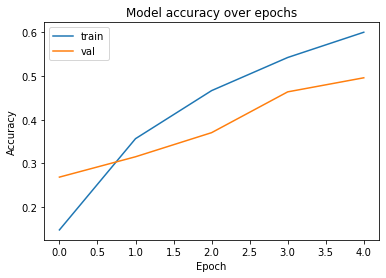

In [27]:

import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy over epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [28]:

# Load all batches of validation generator in memory

nb_batches = len(val_gen)
X_val = np.empty((nb_batches, batch_size, frame_length, 1))
y_val = np.empty((nb_batches, batch_size))

for i in range(nb_batches):
    X_val[i], y_val[i] = val_gen.__getitem__(i)

X_val = X_val.reshape((nb_batches * batch_size, -1))
y_val = y_val.reshape(nb_batches * batch_size)

y_val_actual = np.argmax(sincnet_model.predict(X_val), axis=-1)

2308/2308 [==============================] - 113s 49ms/step


In [29]:

from sklearn.metrics import precision_recall_fscore_support

# https://en.wikipedia.org/wiki/Precision_and_recall

p, r, f1, _ = precision_recall_fscore_support(y_val,
                                              y_val_actual,
                                              average='macro',
                                              zero_division=0)

print("Precision:", p)
print("Recall:", r)
print("F1 score:", f1)

Precision: 0.524415160333594
Recall: 0.49592769189327024
F1 score: 0.4943717461138648


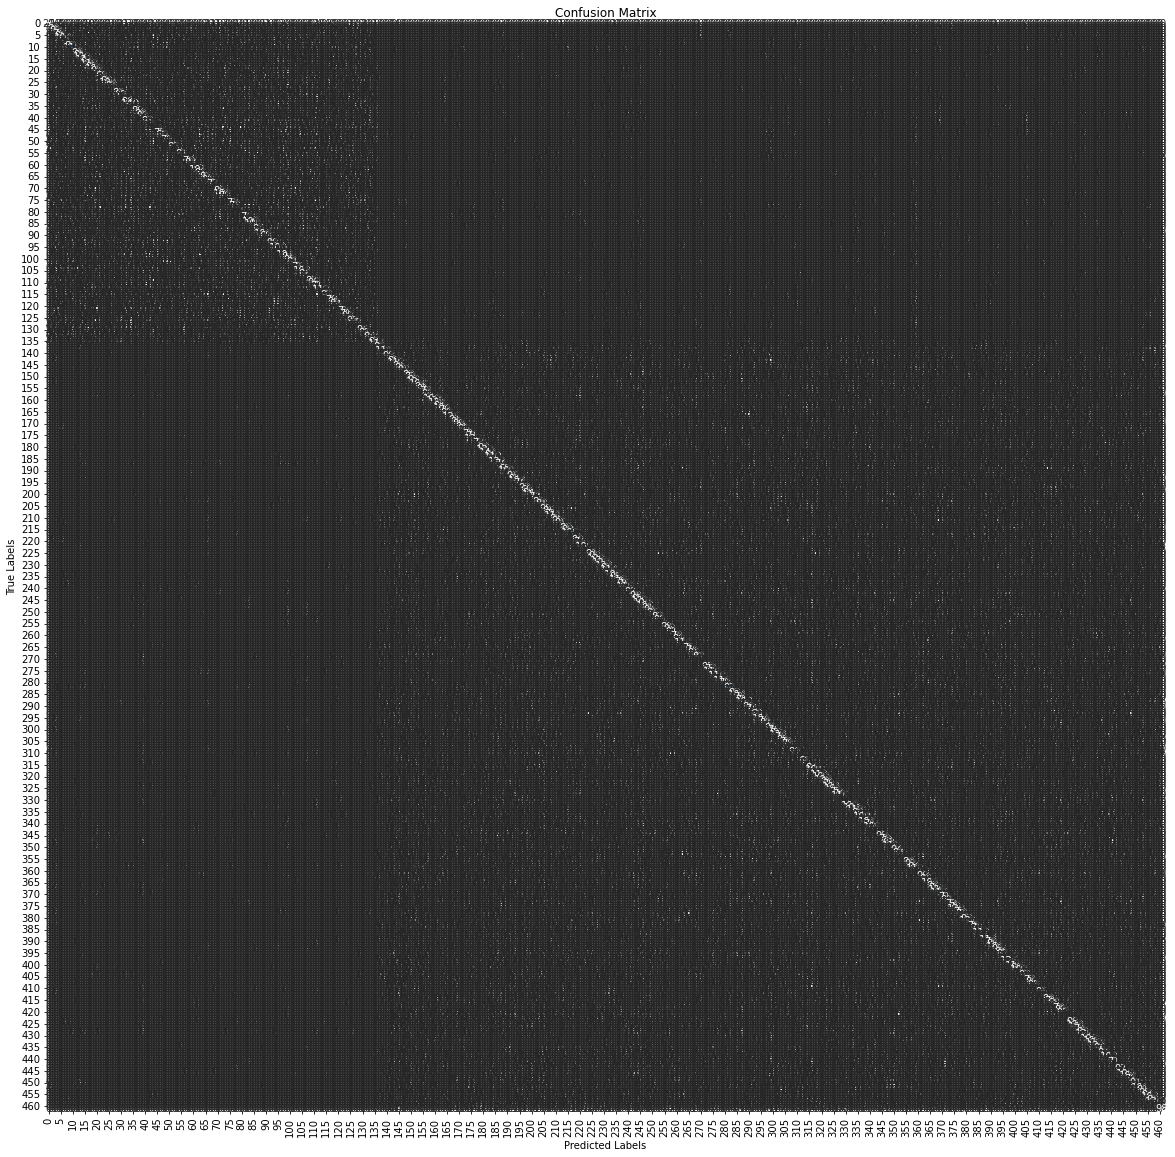

In [33]:
import seaborn as sns
from sklearn.metrics import confusion_matrix


cm = confusion_matrix(y_val, y_val_actual)
plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar= False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [37]:
print(confusion_matrix(y_val[0:10], y_val_actual[0:10]))

[[1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]]


In [39]:
import pickle



# Save the model to a file
with open('./models/sincnet_model.pkl', 'wb') as model_file:
    pickle.dump(sincnet_model, model_file)

In [103]:
number_of_speaker

array([800, 800, 800, 800, 800, 800, 800, 800, 800, 800, 800, 800, 800,
       800, 800, 798, 800, 800, 784, 800, 800, 800, 800, 800, 800, 800,
       800, 800, 800, 800, 800, 800, 800, 800, 800, 800, 800, 800, 800,
       800, 800, 800, 800, 800, 800, 800, 800, 800, 800, 800, 793, 800,
       800, 800, 800, 800, 793, 800, 800, 800, 800, 800, 800, 800, 800,
       800, 800, 800, 800, 800, 800, 800, 800, 800, 800, 800, 800, 800,
       800, 800, 800, 800, 800, 800, 800, 800, 800, 800, 800, 800, 800,
       800, 800, 800, 800, 800, 800, 800, 800, 800, 800, 800, 800, 800,
       800, 800, 776, 800, 800, 800, 800, 800, 800, 800, 800, 800, 800,
       800, 800, 800, 800, 800, 800, 800, 800, 800, 800, 800, 800, 800,
       800, 800, 800, 800, 800, 800, 800, 800, 800, 800, 800, 780, 800,
       800, 800, 800, 800, 800, 790, 800, 800, 800, 800, 800, 800, 800,
       800, 800, 799, 800, 800, 800, 800, 800, 800, 800, 800, 800, 800,
       800, 800, 800, 800, 800, 800, 800, 800, 800, 800, 800, 80

Epoch 1/5


InvalidArgumentError: Graph execution error:

Detected at node 'model/dense/BiasAdd' defined at (most recent call last):
    File "C:\Users\grmus\anaconda3\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\grmus\anaconda3\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\grmus\anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "C:\Users\grmus\anaconda3\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "C:\Users\grmus\anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "C:\Users\grmus\anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\grmus\anaconda3\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "C:\Users\grmus\anaconda3\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "C:\Users\grmus\anaconda3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\grmus\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 471, in dispatch_queue
      await self.process_one()
    File "C:\Users\grmus\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 460, in process_one
      await dispatch(*args)
    File "C:\Users\grmus\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 367, in dispatch_shell
      await result
    File "C:\Users\grmus\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 662, in execute_request
      reply_content = await reply_content
    File "C:\Users\grmus\anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 360, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\Users\grmus\anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\grmus\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2863, in run_cell
      result = self._run_cell(
    File "C:\Users\grmus\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2909, in _run_cell
      return runner(coro)
    File "C:\Users\grmus\anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\grmus\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3106, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\grmus\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3309, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\grmus\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3369, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\grmus\AppData\Local\Temp\ipykernel_11100\251867846.py", line 1, in <cell line: 1>
      history = model.fit(train_gen,
    File "C:\Users\grmus\anaconda3\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\grmus\anaconda3\lib\site-packages\keras\src\engine\training.py", line 1742, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\grmus\anaconda3\lib\site-packages\keras\src\engine\training.py", line 1338, in train_function
      return step_function(self, iterator)
    File "C:\Users\grmus\anaconda3\lib\site-packages\keras\src\engine\training.py", line 1322, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\grmus\anaconda3\lib\site-packages\keras\src\engine\training.py", line 1303, in run_step
      outputs = model.train_step(data)
    File "C:\Users\grmus\anaconda3\lib\site-packages\keras\src\engine\training.py", line 1080, in train_step
      y_pred = self(x, training=True)
    File "C:\Users\grmus\anaconda3\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\grmus\anaconda3\lib\site-packages\keras\src\engine\training.py", line 569, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\grmus\anaconda3\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\grmus\anaconda3\lib\site-packages\keras\src\engine\base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\grmus\anaconda3\lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\grmus\anaconda3\lib\site-packages\keras\src\engine\functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\grmus\anaconda3\lib\site-packages\keras\src\engine\functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\grmus\anaconda3\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\grmus\anaconda3\lib\site-packages\keras\src\engine\base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\grmus\anaconda3\lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\grmus\anaconda3\lib\site-packages\keras\src\layers\core\dense.py", line 252, in call
      outputs = tf.nn.bias_add(outputs, self.bias)
Node: 'model/dense/BiasAdd'
Matrix size-incompatible: In[0]: [128,896], In[1]: [7680,256]
	 [[{{node model/dense/BiasAdd}}]] [Op:__inference_train_function_4655]

In [88]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32000, 1)]        0         
                                                                 
 sinc_conv1d (SincConv1D)    (None, 2000, 64)          128       
                                                                 
 layer_norm (LayerNorm)      (None, 2000, 64)          128       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 2000, 64)          0         
                                                                 
 max_pooling1d (MaxPooling1  (None, 1000, 64)          0         
 D)                                                              
                                                                 
 conv1d (Conv1D)             (None, 998, 64)           12352     
                                                             

[[[-0.073394   -0.09174268 -0.11009065 -0.12843946 -0.14678803
   -0.16513611 -0.18348445 -0.20183372 -0.22018182 -0.23853062
   -0.25687847 -0.27522728 -0.2935761  -0.31192487 -0.3302732
   -0.34862107 -0.36696893 -0.3853177  -0.40366653 -0.42201582
   -0.44036415 -0.45871246 -0.4770608  -0.49540818 -0.51375747
   -0.5321058  -0.5504531  -0.5688024  -0.58715075 -0.60549814
   -0.62384933 -0.6421986  -0.660546   -0.67889243 -0.69724166
   -0.71559286 -0.73394024 -0.75228953 -0.77063596 -0.78898525
   -0.80733454 -0.82568187 -0.84402925 -0.86237663 -0.8807278
   -0.8990771  -0.9174226  -0.9357719  -0.9541212  -0.9724685
   -0.9908197  -1.0091633  -1.0275164  -1.0458599  -1.064215  ]
  [-0.1843509  -0.23043808 -0.27652672 -0.3226144  -0.3687011
   -0.41478878 -0.46087646 -0.50696415 -0.5530528  -0.59913945
   -0.64522713 -0.6913167  -0.7374044  -0.7834883  -0.82957786
   -0.8756655  -0.92175317 -0.96784085 -1.0139285  -1.0600162
   -1.1061039  -1.1521915  -1.1982774  -1.2443688  -1.29045

In [105]:
def create_sincnet(enable_sincconv=True):
    model = Sequential()

    # model.add(LayerNormalization(input_shape=(wlen, 1)))
    if (enable_sincconv):
        model.add(SincConvFast(64, 251, sample_frequency, input_shape=(frame_length, 1)))
    else:
        model.add(Conv1D(filters=64, kernel_size=251, input_shape=(frame_length, 1)))
    model.add(MaxPooling1D(pool_size=3))
    model.add(LayerNormalization())
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv1D(filters=32, kernel_size=5))
    model.add(MaxPooling1D(pool_size=3))
    model.add(LayerNormalization())
    model.add(LeakyReLU(alpha=0.2))

    model.add(Flatten())
    model.add(LayerNormalization())

    model.add(Dense(64))
    model.add(BatchNormalization(momentum=0.05))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dense(64))
    model.add(BatchNormalization(momentum=0.05))
    model.add(LeakyReLU(name='layer_features', alpha=0.2))

    model.add(Dense(number_of_speakers, activation='softmax'))

    return model

sincnet_model = create_sincnet()

In [106]:

sincnet_model.compile(optimizer=RMSprop(learning_rate=0.001),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
     

In [109]:

checkpoint_path = "./checkpoints/training-{epoch:04d}.ckpt"
save_callback = ModelCheckpoint(filepath=checkpoint_path,
                                save_best_only=True,
                                save_weights_only=True,
                                verbose=1)

history = sincnet_model.fit(train_gen,
                            validation_data=val_gen,
                            epochs=5,
                            initial_epoch=0,
                            callbacks=[save_callback])

Epoch 1/5
2308/2308 [==============================] - ETA: 0s - loss: 4.0905 - accuracy: 0.1579
Epoch 1: val_loss improved from inf to 3.22169, saving model to ./checkpoints\training-0001.ckpt
2308/2308 [==============================] - 1931s 837ms/step - loss: 4.0905 - accuracy: 0.1579 - val_loss: 3.2217 - val_accuracy: 0.2589
Epoch 2/5
2308/2308 [==============================] - ETA: 0s - loss: 2.6012 - accuracy: 0.3732
Epoch 2: val_loss improved from 3.22169 to 2.53607, saving model to ./checkpoints\training-0002.ckpt
2308/2308 [==============================] - 1957s 848ms/step - loss: 2.6012 - accuracy: 0.3732 - val_loss: 2.5361 - val_accuracy: 0.3841
Epoch 3/5
1944/2308 [========================>.....] - ETA: 4:53 - loss: 2.0403 - accuracy: 0.4834

KeyboardInterrupt: 

In [95]:
y

<tf.Tensor: shape=(1, 55, 2), dtype=float32, numpy=
array([[[-0.073394  , -0.1843509 ],
        [-0.09174268, -0.23043808],
        [-0.11009065, -0.27652672],
        [-0.12843946, -0.3226144 ],
        [-0.14678803, -0.3687011 ],
        [-0.16513611, -0.41478878],
        [-0.18348445, -0.46087646],
        [-0.20183372, -0.50696415],
        [-0.22018182, -0.5530528 ],
        [-0.23853062, -0.59913945],
        [-0.25687847, -0.64522713],
        [-0.27522728, -0.6913167 ],
        [-0.2935761 , -0.7374044 ],
        [-0.31192487, -0.7834883 ],
        [-0.3302732 , -0.82957786],
        [-0.34862107, -0.8756655 ],
        [-0.36696893, -0.92175317],
        [-0.3853177 , -0.96784085],
        [-0.40366653, -1.0139285 ],
        [-0.42201582, -1.0600162 ],
        [-0.44036415, -1.1061039 ],
        [-0.45871246, -1.1521915 ],
        [-0.4770608 , -1.1982774 ],
        [-0.49540818, -1.2443688 ],
        [-0.51375747, -1.2904565 ],
        [-0.5321058 , -1.3365422 ],
        [-0.

In [108]:
import torch